# 0. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Мы будем использовать метрику ROC_AUC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

# 1. Обработка датасета

In [29]:
train = pd.read_csv('train.csv')
test = pd.read_csv('orange_small_churn_test_data.csv')

In [30]:
train

,Unnamed: 0,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,label
0,38393,NaN,NaN,NaN,NaN,NaN,1127.0,14.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1
1,23485,NaN,NaN,NaN,NaN,NaN,882.0,7.0,NaN,NaN,...,p1jgRjy,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,1
2,14299,NaN,NaN,NaN,NaN,NaN,497.0,0.0,NaN,NaN,...,CNdED8N,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
3,22850,NaN,NaN,NaN,NaN,NaN,1358.0,14.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,PM2D,ZI9m,ib5G6X1eUxUn6,am7c,NaN,-1
4,5697,NaN,NaN,NaN,NaN,NaN,1092.0,7.0,NaN,NaN,...,fV_z4Af,LM8l689qOp,NaN,ELof,7aLG,RAYp,55YFVY9,am7c,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34395,6265,NaN,NaN,NaN,NaN,NaN,1064.0,7.0,NaN,NaN,...,PgO2Oqu,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
34396,11284,NaN,NaN,NaN,NaN,NaN,1246.0,7.0,NaN,NaN,...,K2SqEo9,LM8l689qOp,NaN,ELof,szEZ,6fzt,4rd_,NaN,NaN,-1
34397,38158,NaN,NaN,NaN,NaN,NaN,777.0,7.0,NaN,NaN,...,W41oG9v,M_8D,NaN,kG3k,Qu4f,RAYp,F2FyR07IdsN7I,mj86,NaN,-1
34398,860,NaN,NaN,NaN,NaN,NaN,504.0,NaN,NaN,NaN,...,05j67Xw,LM8l689qOp,NaN,ELof,rgKb,RAYp,R4y5gQQWY8OodqDV,am7c,NaN,-1


In [31]:
nonempty_columns = train.columns[np.sum(train.isna(), axis=0) < 34400]

numeric_columns = train.columns[1:191]
numeric_columns = numeric_columns & nonempty_columns

categorical_columns = train.columns[191:-1]
categorical_columns = categorical_columns & nonempty_columns

train = train[nonempty_columns]

y_train = train['label']

In [32]:
mean_numerical_values = train[numeric_columns].mean()

X_numeric = train[numeric_columns].fillna(mean_numerical_values)
X_categorical = train[categorical_columns].fillna('Not_known')

X_test_numeric = test[numeric_columns].fillna(mean_numerical_values)
X_test_categorical = test[categorical_columns].fillna('Not_known')

X_train = pd.concat([X_numeric, X_categorical], axis=1)
X_test = pd.concat([X_test_numeric, X_test_categorical], axis=1)

# 2.0 CatBoost

In [33]:
from catboost import CatBoostClassifier

In [34]:
X_train

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,10.507937,0.005708,442.957714,0.168224,243194.454454,1127.0,14.000000,44.039683,386761.873874,8.566857,...,4UxGlow,zCkv,catzS2D,LM8l689qOp,Not_known,ELof,FSa2,ZI9m,ib5G6X1eUxUn6,mj86
1,10.507937,0.005708,442.957714,0.168224,243194.454454,882.0,7.000000,44.039683,386761.873874,8.566857,...,nJQDBnE,oslk,p1jgRjy,LM8l689qOp,Not_known,Not_known,FSa2,RAYp,F2FyR07IdsN7I,Not_known
2,10.507937,0.005708,442.957714,0.168224,243194.454454,497.0,0.000000,44.039683,386761.873874,8.566857,...,2X58jNM,oslk,CNdED8N,LM8l689qOp,Not_known,Not_known,fKCe,RAYp,F2FyR07IdsN7I,Not_known
3,10.507937,0.005708,442.957714,0.168224,243194.454454,1358.0,14.000000,44.039683,386761.873874,8.566857,...,4UxGlow,oslk,catzS2D,LM8l689qOp,Not_known,ELof,PM2D,ZI9m,ib5G6X1eUxUn6,am7c
4,10.507937,0.005708,442.957714,0.168224,243194.454454,1092.0,7.000000,44.039683,386761.873874,8.566857,...,1hf8iqZ,oslk,fV_z4Af,LM8l689qOp,Not_known,ELof,7aLG,RAYp,55YFVY9,am7c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34395,10.507937,0.005708,442.957714,0.168224,243194.454454,1064.0,7.000000,44.039683,386761.873874,8.566857,...,iEXOjel,oslk,PgO2Oqu,LM8l689qOp,Not_known,Not_known,WqMG,RAYp,F2FyR07IdsN7I,Not_known
34396,10.507937,0.005708,442.957714,0.168224,243194.454454,1246.0,7.000000,44.039683,386761.873874,8.566857,...,ROeipLp,zCkv,K2SqEo9,LM8l689qOp,Not_known,ELof,szEZ,6fzt,4rd_,Not_known
34397,10.507937,0.005708,442.957714,0.168224,243194.454454,777.0,7.000000,44.039683,386761.873874,8.566857,...,TLbNioI,oslk,W41oG9v,M_8D,Not_known,kG3k,Qu4f,RAYp,F2FyR07IdsN7I,mj86
34398,10.507937,0.005708,442.957714,0.168224,243194.454454,504.0,6.787428,44.039683,386761.873874,8.566857,...,WdP1WU5,oslk,05j67Xw,LM8l689qOp,Not_known,ELof,rgKb,RAYp,R4y5gQQWY8OodqDV,am7c


In [35]:
cat_features = list(range(174, X_train.shape[1]))
print(cat_features)

[174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211]


In [36]:
%%time
model = CatBoostClassifier()#,
    #use_best_model=True)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    #eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)
labels = model.predict(X_test)
y_test = model.predict_proba(X_test)[:, 1]
test['result'] = y_test
assignment = test[['ID', 'result']]
assignment.to_csv('assignment_catboost.csv', index=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 9min 53s, sys: 18.5 s, total: 10min 12s
Wall time: 3min 1s


In [37]:
assignment

,ID,result
0,0,0.101050
1,1,0.119767
2,2,0.024944
3,3,0.075904
4,4,0.030828
...,...,...
9995,9995,0.022560
9996,9996,0.038395
9997,9997,0.037152
9998,9998,0.023163


# Score = 0.72977
Вроде 0,84 объем тестовой выборки

# 2. Трансформация данных

Для числовых значений, всё просто - мы просто заскейлим их, как обычно. Но что делать с категориальными? Понятное дело, что мы будем использовать onehotencoding на большинстве из них, однако что делать с данными с большим количеством категорий? Благодаря второй недели, от одного коллеги, чьё имя я к своему стыду не запомнил, я столкнулся с любопытным методом, а именно:
* 1. Нумерация разных категорий разными числами
* 2. Представление чисел в бинарной форме
* 3. Создание на основе этих бинарных чисел бинарных категорий

Этот метод прекрасен тем, что позволяет нам закодировать n категорий не n - 1 столбцом, а логарифмом по основанию два числа n. Например, для 1024 категорий достаточно 10 столбцов, потому что 1024 - это 2 в десятой.

Для начала нам надо разбить категории на малые и большие, посмотрим на распределение

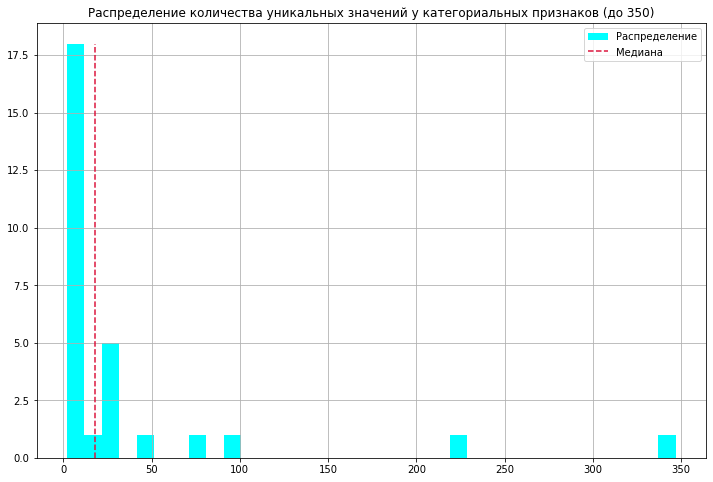

In [55]:
ax = X_categorical.nunique()[X_categorical.nunique()<350].hist(figsize=(12, 8), color='aqua', bins=35, label='Распределение')
ax.set_title('Распределение количества уникальных значений у категориальных признаков (до 350)')
ax.vlines(X_categorical.nunique().median(), 0, 18, linestyle='--', color='crimson', label='Медиана')
ax.legend();

In [56]:
X_categorical.nunique().median()

18.0

Мерилом размера будем использовать число 18

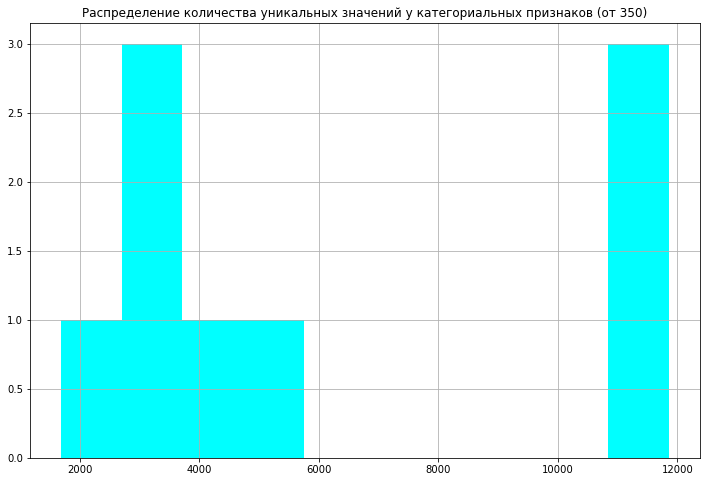

In [57]:
ax = X_categorical.nunique()[X_categorical.nunique()>=350].hist(figsize=(12, 8), color='aqua')
ax.set_title('Распределение количества уникальных значений у категориальных признаков (от 350)');

In [58]:
small_columns = categorical_columns[X_categorical.nunique()<=18]
big_columns = categorical_columns[X_categorical.nunique()>18]

In [59]:
preprocessor = ColumnTransformer(
    transformers=[
        ('nc', StandardScaler(), numeric_columns),
        ('sc', OneHotEncoder(handle_unknown="ignore"), small_columns),
        ('bc', BinaryEncoder(handle_unknown="value"), big_columns)
    ])

# 3. Другие алгоритмы

## 3.1 XGBoost

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [11]:
X_transformed = preprocessor.fit_transform(X_train)

In [12]:
from xgboost import XGBClassifier

In [13]:
%%time
n_list = [int(i) for i in np.linspace(10, 100, 10)]
res_list = []

for n in n_list:
    xgb = XGBClassifier(n_estimators=n, n_jobs=-1, objective='binary:logistic', eval_metric='logloss')
    res = cross_val_score(xgb, X_transformed, y_train, cv=skf, scoring='roc_auc')
    res_list.append(res.mean())

CPU times: user 45min 1s, sys: 9.58 s, total: 45min 10s
Wall time: 12min 27s


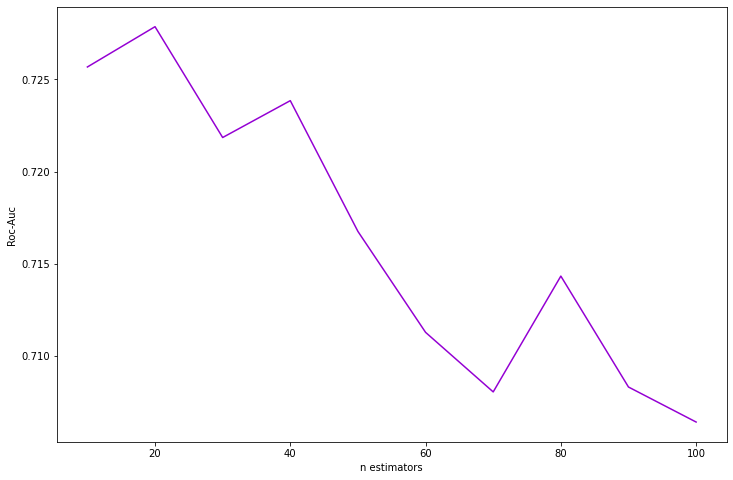

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(n_list, res_list, color='darkviolet')
plt.xlabel('n estimators')
plt.ylabel('Roc-Auc');

In [15]:
%%time
n_list = [int(i) for i in np.linspace(1, 20, 20)]
res_list = []

for n in n_list:
    xgb = XGBClassifier(n_estimators=n, n_jobs=-1, objective='binary:logistic', eval_metric='logloss')
    res = cross_val_score(xgb, X_transformed, y_train, cv=skf, scoring='roc_auc')
    res_list.append(res.mean())

CPU times: user 18min 20s, sys: 10.8 s, total: 18min 31s
Wall time: 4min 54s


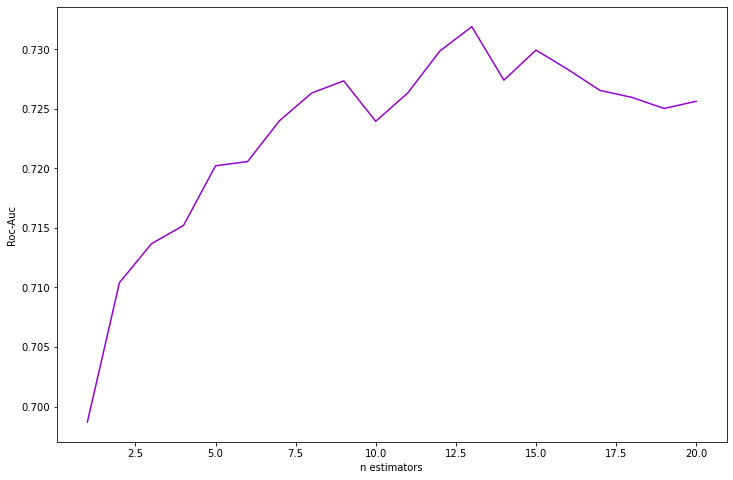

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(n_list, res_list, color='darkviolet')
plt.xlabel('n estimators')
plt.ylabel('Roc-Auc');

In [17]:
candidates = list(zip(res_list, n_list))
candidates.sort(reverse=True)
candidates

[(0.7319027707697006, 13),
 (0.7299358243931948, 15),
 (0.7298554939460578, 12),
 (0.7283084361151289, 16),
 (0.7274103104306814, 14),
 (0.727352266404201, 9),
 (0.7265486193129375, 17),
 (0.7263368099576046, 11),
 (0.7263284953018937, 8),
 (0.7259618493647859, 18),
 (0.7256336951629703, 20),
 (0.7250334952346215, 19),
 (0.7240166817030067, 7),
 (0.7239538244584155, 10),
 (0.7205758854210693, 6),
 (0.7202171595710396, 5),
 (0.7152088584624063, 4),
 (0.7136732854864444, 3),
 (0.7103988142216069, 2),
 (0.6986985024929979, 1)]

### Тест

In [18]:
pipe = Pipeline([('prep', preprocessor),
                 ('xgbc', XGBClassifier(n_estimators=12, n_jobs=-1, objective='binary:logistic', 
                                        eval_metric='logloss'))])
pipe.fit(X_train, y_train)
labels = pipe.predict(X_test)
y_test = pipe.predict_proba(X_test)[:, 1]
test['result'] = y_test
assignment = test[['ID', 'result']]
assignment.to_csv('assignment_xgboost.csv', index=False)

# Score =  0.70848

Но на всякий случай попробуем прогнать ещё и логистическую регрессию с random forest. Предполагается, что наша версия о том, что они работают в нашей задаче хуже, чем XGBoost, подтвердится.

## 3.2 Логистическая регрессия

In [10]:
#skf = StratifiedKFold(n_splits=5, shuffle=True)

In [11]:
#X_transformed = preprocessor.fit_transform(X_train)

In [20]:
C_list = np.linspace(0.1, 10, 20)
res_list = []

for C in C_list:
    lr = LogisticRegression(C=C)
    res = cross_val_score(lr, X_transformed, y_train, cv=skf, scoring='roc_auc')
    res_list.append(res.mean())

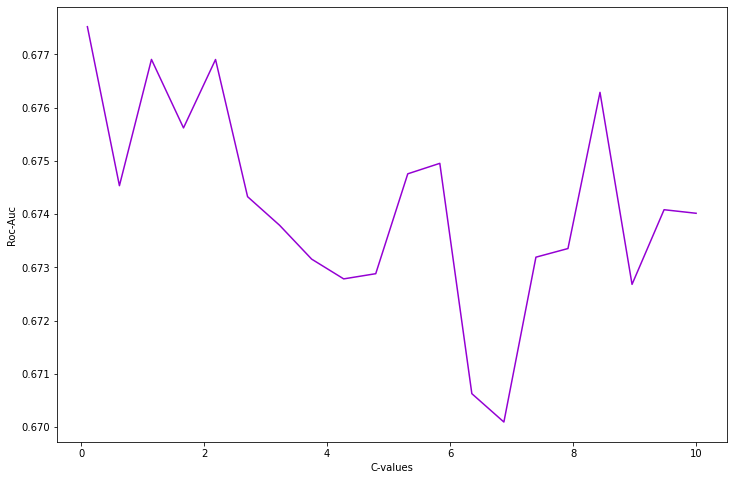

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(C_list, res_list, color='darkviolet')
plt.xlabel('C-values')
plt.ylabel('Roc-Auc');

In [22]:
C_list = np.linspace(0.1, 2, 20)
res_list = []

for C in C_list:
    lr = LogisticRegression(C=C)
    res = cross_val_score(lr, X_transformed, y_train, cv=skf, scoring='roc_auc')
    res_list.append(res.mean())

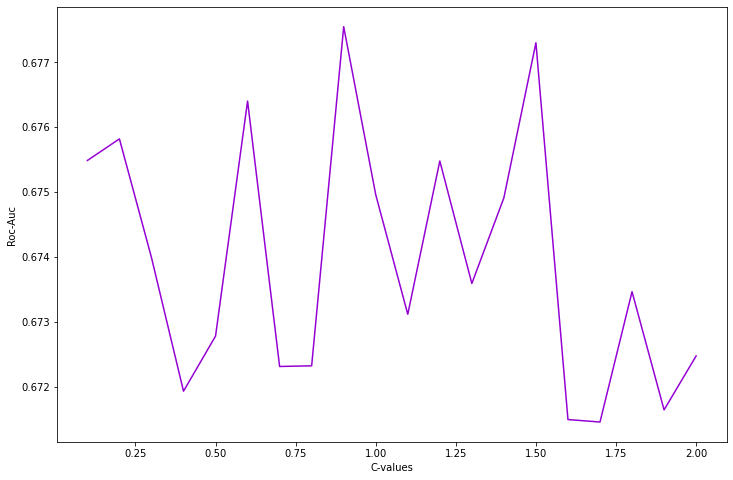

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(C_list, res_list, color='darkviolet')
plt.xlabel('C-values')
plt.ylabel('Roc-Auc');

### Тест

In [24]:
pipe = Pipeline([('prep', preprocessor), ('lr', LogisticRegression(C=0.2))])
pipe.fit(X_train, y_train)
labels = pipe.predict(X_test)
y_test = pipe.predict_proba(X_test)[:, 1]
test['result'] = y_test
assignment = test[['ID', 'result']]
assignment.to_csv('assignment_lr.csv', index=False)

# Score =  0.67773

## 3.3 Random Forest

In [25]:
from xgboost import XGBRFClassifier

In [26]:
%%time
n_list = [int(i) for i in np.linspace(10, 100, 10)]
res_list = []

for n in n_list:
    xgb = XGBRFClassifier(n_estimators=n, n_jobs=-1, objective='binary:logistic', eval_metric='logloss')
    res = cross_val_score(xgb, X_transformed, y_train, cv=skf, scoring='roc_auc')
    res_list.append(res.mean())

CPU times: user 37min 31s, sys: 6.09 s, total: 37min 37s
Wall time: 9min 39s


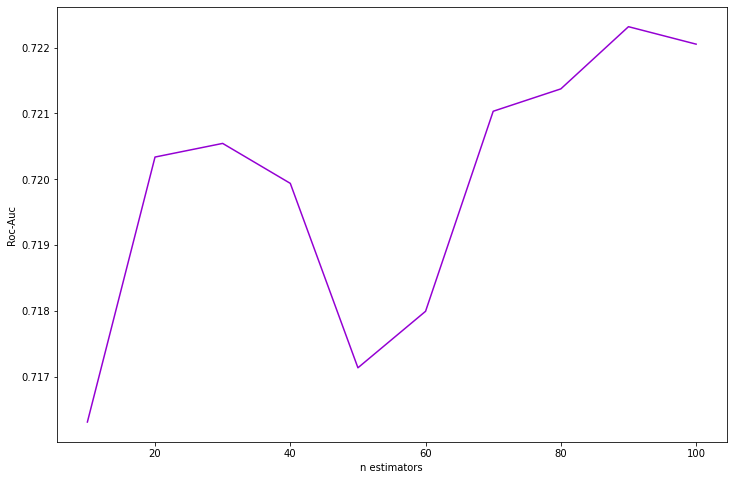

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(n_list, res_list, color='darkviolet')
plt.xlabel('n estimators')
plt.ylabel('Roc-Auc');

In [52]:
%%time
n_list_1 = [int(i) for i in np.linspace(110, 200, 10)]

for n in n_list_1:
    xgb = XGBRFClassifier(n_estimators=n, n_jobs=-1, objective='binary:logistic', eval_metric='logloss')
    res = cross_val_score(xgb, X_transformed, y_train, cv=skf, scoring='roc_auc')
    res_list.append(res.mean())
    n_list.append(n)

Wall time: 9min 17s


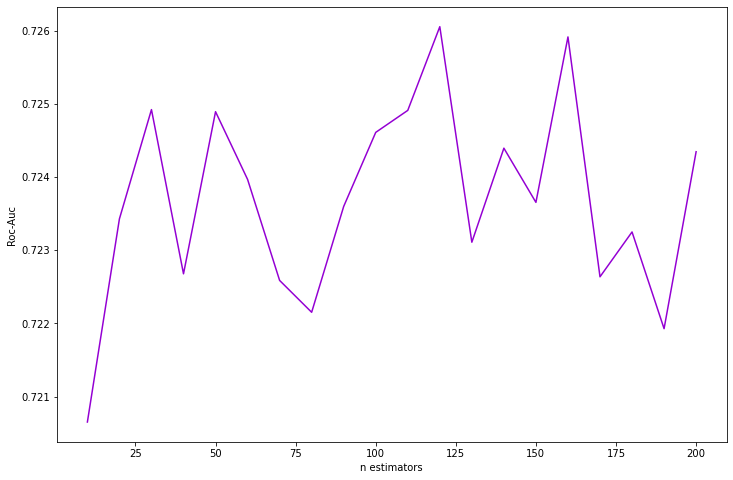

In [53]:
plt.figure(figsize=(12, 8))
plt.plot(n_list, res_list, color='darkviolet')
plt.xlabel('n estimators')
plt.ylabel('Roc-Auc');

In [54]:
candidates = list(zip(res_list, n_list))
candidates.sort(reverse=True)
candidates

[(0.7260555256213648, 120),
 (0.7259155466464705, 160),
 (0.7249221292378336, 30),
 (0.7249114534075367, 110),
 (0.7248936812900422, 50),
 (0.7246108031866725, 100),
 (0.7243948060201634, 140),
 (0.7243461053943087, 200),
 (0.7239679612052887, 60),
 (0.7236541545935585, 150),
 (0.7235986402760142, 90),
 (0.7234287689762884, 20),
 (0.723249572024803, 180),
 (0.7231094046529037, 130),
 (0.7226775987168907, 40),
 (0.722636559569249, 170),
 (0.7225870739558723, 70),
 (0.7221516570772591, 80),
 (0.7219276844375282, 190),
 (0.7206514203250226, 10)]

### Teст

In [55]:
pipe = Pipeline([('prep', preprocessor),
                 ('xgbrfc', XGBRFClassifier(n_estimators=120, n_jobs=-1, objective='binary:logistic', 
                                            eval_metric='logloss'))])
pipe.fit(X_train, y_train)
labels = pipe.predict(X_test)
y_test = pipe.predict_proba(X_test)[:, 1]
test['result'] = y_test
assignment = test[['ID', 'result']]
assignment.to_csv('assignment_xgbrf.csv', index=False)

# Score = 0.69673

### Более тщательный подбор параметров

In [56]:
%%time
n_list = [int(i) for i in np.linspace(115, 125, 11)]
res_list = []

for n in n_list:
    xgb = XGBRFClassifier(n_estimators=n, n_jobs=-1, objective='binary:logistic', eval_metric='logloss')
    res = cross_val_score(xgb, X_transformed, y_train, cv=skf, scoring='roc_auc')
    res_list.append(res.mean())

Wall time: 8min 29s


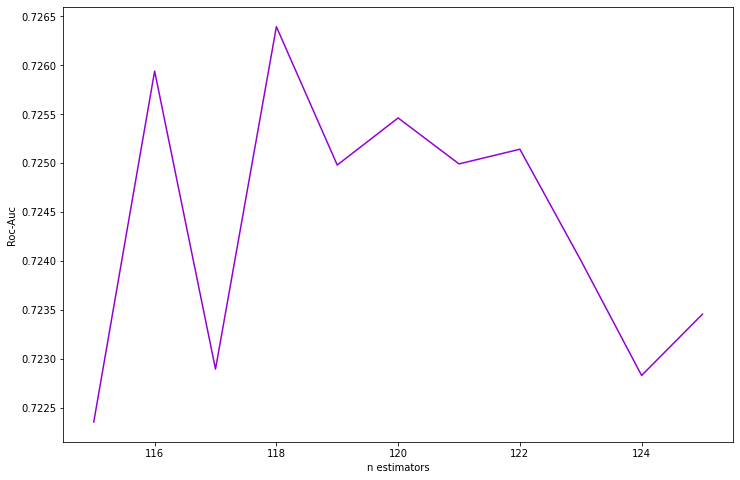

In [57]:
plt.figure(figsize=(12, 8))
plt.plot(n_list, res_list, color='darkviolet')
plt.xlabel('n estimators')
plt.ylabel('Roc-Auc');

In [58]:
n_best=118

### Подбор lambda и max_depth

In [64]:
%%time
l_list = list(range(5))
d_list = list(range(4, 8))
acc_list = [[0] * 5 for i in range(4)]

for i in range(4):
    for j in range(5):
        xgb = XGBRFClassifier(n_estimators=118, n_jobs=-1, objective='binary:logistic', eval_metric='logloss',
                              max_depth=d_list[i], reg_lambda=l_list[j])
        res = cross_val_score(xgb, X_transformed, y_train, cv=skf, scoring='roc_auc')
        acc_list[i][j] = res.mean()

Wall time: 13min 8s


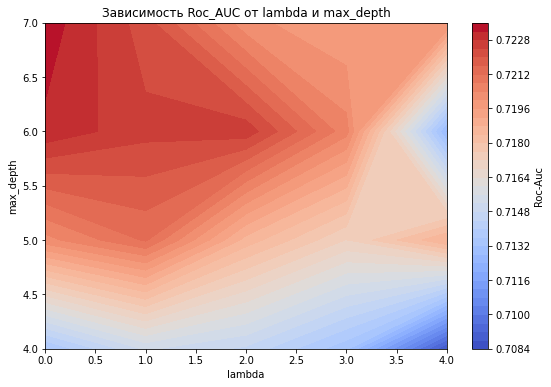

In [67]:
fig, ax = plt.subplots(figsize=(9, 6))
cs = ax.contourf(l_list, d_list, np.array(acc_list), cmap=cm.coolwarm, levels=40)
cbar = fig.colorbar(cs)
cbar.set_label('Roc-Auc')
plt.title('Зависимость Roc_AUC от lambda и max_depth')
plt.xlabel('lambda')
plt.ylabel('max_depth');

In [68]:
%%time
l_list = np.linspace(0.1, 2, 5)
d_list = list(range(6, 10))
acc_list = [[0] * 5 for i in range(4)]

for i in range(4):
    for j in range(5):
        xgb = XGBRFClassifier(n_estimators=118, n_jobs=-1, objective='binary:logistic', eval_metric='logloss',
                              max_depth=d_list[i], reg_lambda=l_list[j])
        res = cross_val_score(xgb, X_transformed, y_train, cv=skf, scoring='roc_auc')
        acc_list[i][j] = res.mean()

Wall time: 17min 23s


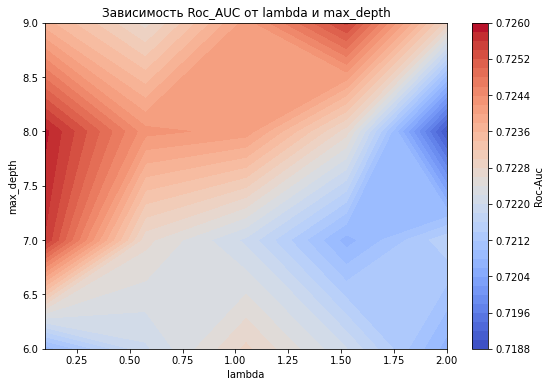

In [69]:
fig, ax = plt.subplots(figsize=(9, 6))
cs = ax.contourf(l_list, d_list, np.array(acc_list), cmap=cm.coolwarm, levels=40)
cbar = fig.colorbar(cs)
cbar.set_label('Roc-Auc')
plt.title('Зависимость Roc_AUC от lambda и max_depth')
plt.xlabel('lambda')
plt.ylabel('max_depth');

In [70]:
max_depth = 8
reg_lambda = 0.1

### Teст

In [28]:
pipe = Pipeline([('prep', preprocessor),
                 ('xgbrfc', XGBRFClassifier(n_estimators=120, n_jobs=-1, objective='binary:logistic', 
                                            eval_metric='logloss', max_depth=8, reg_lambda=0.1))])
pipe.fit(X_train, y_train)
labels = pipe.predict(X_test)
y_test = pipe.predict_proba(X_test)[:, 1]
test['result'] = y_test
assignment = test[['ID', 'result']]
assignment.to_csv('assignment_tuned_xgbrf.csv', index=False)

# Score = 0.70930

# Вывод: 
Как и ожидалось, наилучший score был достигнут на CatBoost и равен 0.71901.
За второе место по score могут побороться XGBoost и Random Forest, если хорошо подобрать гиперпараметры.
Логистическая регрессия вчистую проигрывает всем.